In [49]:
# Juptyer-sepcifics
from IPython.display import clear_output, Markdown, display

# Python basics & calculus
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
from datetime import datetime, timedelta

# ETL
import pandas as pd
import sklearn as scl


# visualization
import bokeh
from dataprep.eda import create_report
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from IPython.display import HTML

# models
import skl2onnx
import xgboost
import xgboost.sklearn

from sklearn import datasets, metrics, model_selection, svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, plot_roc_curve
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB


# Ethics, Fairness & Explainability
import aif360
from aif360.sklearn.datasets import fetch_adult
from aif360.sklearn.metrics import disparate_impact_ratio, average_odds_error, generalized_fpr, generalized_fnr, difference
from aif360.datasets import GermanDataset, StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover, Reweighing

import shap


In [3]:
# configure Jupyter displays
%matplotlib inline

pd.set_option("display.max_rows", 128)
pd.set_option("display.max_columns", 32)
pd.set_option("precision", 3)

clear_output(wait=True)

plt.rcParams["figure.figsize"] = (15, 9)
plt.rc('figure', figsize=(15, 9))

In [4]:
# CONSTANTS
DATE_DATETIME_FORMAT = '%Y-%m-%d, %H:%M:%S'
DATE_DATEONLY_FORMAT = '%Y-%m-%d'
DATE_YEAR_MONTH_FORMAT = '%Y-%m'
DATE_DATA_COLLECTION = datetime(2021, 1, 1)
DATE_WEEKS_PER_MONTH = 4.34

# UTIL FUNCTIONS
def get_formatted_date(date, 
                       format_string=DATE_DATETIME_FORMAT):
    """
    Return nothing (`void`) for invalid date instances. Return the 
    pretty-formatted date for valid dates. The default format string 
    may be replaced in the field `format_string`.
    """
    return date.strftime(format_string) if date else None

def is_natural_number(number):
    if (type(number) != int) or (type(number) == bool) or (not number):
        return None
    
    if number == 0:
        return True
    
    return number % 1 == 0

def get_year_month_from_offset_as_date(date, 
                                       offset_months=0,
                                       weeks_per_month=DATE_WEEKS_PER_MONTH,
                                       reset_to_first_of_month=True,
                                       format_string=None):
    """
    Return a date instance relative to `date` a couple of months 
    in the past w/ positive values in `offset_months`. Dates 
    relative to `date` in the future use negative values 
    in `offset_months`. When `reset_to_first_of_month` is `True`, 
    the returned `datetime` instance will be first of this month 
    with hours, minutes and seconds set to zero each. 
    When giving no format string to `format_string`, an instance of 
    `datetime` will be returned. When providing it, a string will 
    be returned in the specified format. This date text format 
    will not be further checked.
    If no valid date instance is given, 
    `void` is being returned.
    """
    # check for @NotNull
    if not date:
        return None
    
    # calculate weeks to go backwards into the past (-) or future (+)
    weeks = offset_months * weeks_per_month
    past_date = date + timedelta(weeks=weeks)
    
    # reset to 1st of month and time to 00:00:00
    if reset_to_first_of_month:
        past_date = datetime(past_date.year, past_date.month, 1)
        
    # possibly format the instance of `datetime` to text
    if (type(format_string) == str) and 0 < len(format_string):
        past_date = get_formatted_date(date=past_date, format_string=format_string)
    
    return past_date


In [5]:
card_balances_pq = pq.read_table('../data/processed/credit_card_balances.parquet')
card_balances = card_balances_pq.to_pandas()
card_balances.head()

,id,months_balance,status_code,year_month
0,5001711,0,X,2021-01-01
1,5001711,-1,0,2020-12-01
2,5001711,-2,0,2020-11-01
3,5001711,-3,0,2020-10-01
4,5001712,0,C,2021-01-01


In [6]:
apps_pq = pq.read_table('../data/processed/credit_masterdata.parquet')
apps = apps_pq.to_pandas()
apps.head()

,id,gender_code,family_status,has_own_car,has_own_real_estate,amount_income_total,income_type,education_type,housing_type,days_since_birth,days_tenure,has_private_mobile_phone,has_work_phone,has_phone,has_email,occupation_type,number_children,number_family_members,customer_lifetime_value,cltv_class,cltv_binary
0,5008804,M,Civil marriage,Y,Y,427500.0,Working,Higher education,Rented apartment,-12005,-4542,1,1,0,0,None,0,2.0,-23.0,medium,1
1,5008805,M,Civil marriage,Y,Y,427500.0,Working,Higher education,Rented apartment,-12005,-4542,1,1,0,0,None,0,2.0,-29.0,medium,1
2,5008806,M,Married,Y,Y,112500.0,Working,Secondary / secondary special,House / apartment,-21474,-1134,1,0,0,0,Security staff,0,2.0,-1528.0,watch,-1
3,5008808,F,Single / not married,N,Y,270000.0,Commercial associate,Secondary / secondary special,House / apartment,-19110,-3051,1,0,1,1,Sales staff,0,1.0,-293.0,medium,1
4,5008809,F,Single / not married,N,Y,270000.0,Commercial associate,Secondary / secondary special,House / apartment,-19110,-3051,1,0,1,1,Sales staff,0,1.0,-495.0,medium,1


In [7]:
TESTSET_RATIO = .3
TARGET_VARIABLE = 'cltv_binary'
TARGET_VARIABLES_COMPLEXERONES = ['customer_lifetime_value', 'cltv_class']
TARGET_VARIABLES = ['customer_lifetime_value', 'cltv_class', TARGET_VARIABLE]

TECH_RANDOM_STATE = 1337

In [8]:
apps_prepro = pd.DataFrame(data=apps)

labeler_gender = LabelEncoder()
labeler_famstatus = LabelEncoder()
labeler_owncar = LabelEncoder()
labeler_ownre = LabelEncoder()
labeler_income = LabelEncoder()
labeler_education = LabelEncoder()
labeler_housing = LabelEncoder()
labeler_occupation = LabelEncoder()


def transform_df_features(apps_prepro, 
                          labeler_gender=labeler_gender,
                          labeler_famstatus=labeler_famstatus,
                          labeler_owncar=labeler_owncar,
                          labeler_ownre=labeler_ownre,
                          labeler_income=labeler_income,
                          labeler_education=labeler_education,
                          labeler_housing=labeler_housing,
                          labeler_occupation=labeler_occupation):
    """
    Transform labels in a DataFrame to get rid of texts in features.
    """
    
    apps_prepro['gender_code'] = labeler_gender.fit_transform(apps_prepro['gender_code'])
    apps_prepro['family_status'] = labeler_famstatus.fit_transform(apps_prepro['family_status'])
    apps_prepro['has_own_car'] = labeler_owncar.fit_transform(apps_prepro['has_own_car'])
    apps_prepro['has_own_real_estate'] = labeler_ownre.fit_transform(apps_prepro['has_own_real_estate'])
    apps_prepro['income_type'] = labeler_income.fit_transform(apps_prepro['income_type'])
    apps_prepro['education_type'] = labeler_education.fit_transform(apps_prepro['education_type'])
    apps_prepro['housing_type'] = labeler_housing.fit_transform(apps_prepro['housing_type'])
    apps_prepro['occupation_type'] = labeler_occupation.fit_transform(apps_prepro['occupation_type'])
        
    return apps_prepro


def restore_df_features(apps_prepro, 
                        labeler_gender=labeler_gender,
                        labeler_famstatus=labeler_famstatus,
                        labeler_owncar=labeler_owncar,
                        labeler_ownre=labeler_ownre,
                        labeler_income=labeler_income,
                        labeler_education=labeler_education,
                        labeler_housing=labeler_housing,
                        labeler_occupation=labeler_occupation):
    """
    Transform labels back to human-readable form in a DataFrame.
    """
    
    apps_prepro['gender_code'] = labeler_gender.inverse_transform(apps_prepro['gender_code'])
    apps_prepro['family_status'] = labeler_famstatus.inverse_transform(apps_prepro['family_status'])
    apps_prepro['has_own_car'] = labeler_owncar.inverse_transform(apps_prepro['has_own_car'])
    apps_prepro['has_own_real_estate'] = labeler_ownre.inverse_transform(apps_prepro['has_own_real_estate'])
    apps_prepro['income_type'] = labeler_income.inverse_transform(apps_prepro['income_type'])
    apps_prepro['education_type'] = labeler_education.inverse_transform(apps_prepro['education_type'])
    apps_prepro['housing_type'] = labeler_housing.inverse_transform(apps_prepro['housing_type'])
    apps_prepro['occupation_type'] = labeler_occupation.inverse_transform(apps_prepro['occupation_type'])
        
    return apps_prepro


apps_prepro = pd.DataFrame(data=transform_df_features(apps_prepro))

apps_prepro_wo_sometargets = pd.DataFrame(data=apps_prepro).drop(TARGET_VARIABLES_COMPLEXERONES,
                                                                 axis='columns')




features = apps.drop(TARGET_VARIABLES, axis='columns')
target = apps.loc[:, TARGET_VARIABLE == apps.columns]

X_train, X_test, Y_train, Y_test = train_test_split(features,
                                                    target,
                                                    test_size=TESTSET_RATIO,
                                                    random_state=TECH_RANDOM_STATE)

In [9]:
apps_prepro_wo_sometargets

,id,gender_code,family_status,has_own_car,has_own_real_estate,amount_income_total,income_type,education_type,housing_type,days_since_birth,days_tenure,has_private_mobile_phone,has_work_phone,has_phone,has_email,occupation_type,number_children,number_family_members,cltv_binary
0,5008804,1,0,1,1,427500.0,4,1,4,-12005,-4542,1,1,0,0,18,0,2.0,1
1,5008805,1,0,1,1,427500.0,4,1,4,-12005,-4542,1,1,0,0,18,0,2.0,1
2,5008806,1,1,1,1,112500.0,4,4,1,-21474,-1134,1,0,0,0,16,0,2.0,-1
3,5008808,0,3,0,1,270000.0,0,4,1,-19110,-3051,1,0,1,1,14,0,1.0,1
4,5008809,0,3,0,1,270000.0,0,4,1,-19110,-3051,1,0,1,1,14,0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434808,5149828,1,1,1,1,315000.0,4,4,1,-17348,-2420,1,0,0,0,10,0,2.0,-1
434809,5149834,0,1,0,1,157500.0,0,1,1,-12387,-1325,1,0,1,1,11,0,2.0,-1
434810,5149838,0,1,0,1,157500.0,1,1,1,-12387,-1325,1,0,1,1,11,0,2.0,1
434811,5150049,0,1,0,1,283500.0,4,4,1,-17958,-655,1,0,0,0,14,0,2.0,1


In [10]:
features

,id,gender_code,family_status,has_own_car,has_own_real_estate,amount_income_total,income_type,education_type,housing_type,days_since_birth,days_tenure,has_private_mobile_phone,has_work_phone,has_phone,has_email,occupation_type,number_children,number_family_members
0,5008804,1,0,1,1,427500.0,4,1,4,-12005,-4542,1,1,0,0,18,0,2.0
1,5008805,1,0,1,1,427500.0,4,1,4,-12005,-4542,1,1,0,0,18,0,2.0
2,5008806,1,1,1,1,112500.0,4,4,1,-21474,-1134,1,0,0,0,16,0,2.0
3,5008808,0,3,0,1,270000.0,0,4,1,-19110,-3051,1,0,1,1,14,0,1.0
4,5008809,0,3,0,1,270000.0,0,4,1,-19110,-3051,1,0,1,1,14,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434808,5149828,1,1,1,1,315000.0,4,4,1,-17348,-2420,1,0,0,0,10,0,2.0
434809,5149834,0,1,0,1,157500.0,0,1,1,-12387,-1325,1,0,1,1,11,0,2.0
434810,5149838,0,1,0,1,157500.0,1,1,1,-12387,-1325,1,0,1,1,11,0,2.0
434811,5150049,0,1,0,1,283500.0,4,4,1,-17958,-655,1,0,0,0,14,0,2.0


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Liblinear failed to converge, increase the number of iterations.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting wi

[20:51:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Text(0.5, 1.0, 'According to our ROC Curve, various models perform better or worse')

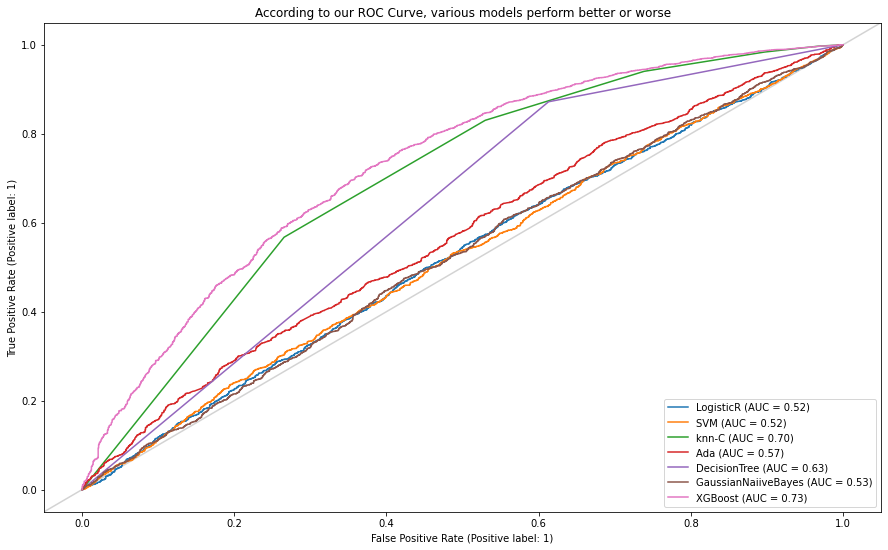

In [13]:
fig, ax = plt.subplots()
ax.axline((1, 1), slope=1, color='lightgrey')


models = [
    ('LogisticR', LogisticRegression(random_state=TECH_RANDOM_STATE)),
    ('SVM', LinearSVC(random_state=TECH_RANDOM_STATE)),
    ('knn-C', KNeighborsClassifier()),
    ('Ada', AdaBoostClassifier(random_state=TECH_RANDOM_STATE)),
    ('DecisionTree', DecisionTreeClassifier(random_state=TECH_RANDOM_STATE)),
    ('GaussianNaiiveBayes', GaussianNB()),
    ('XGBoost', xgboost.XGBClassifier(random_state=TECH_RANDOM_STATE)),
]

model_displays = {}
for name, pipeline in models:
    p = pipeline.fit(X_train, Y_train)
    model_displays[name] = plot_roc_curve(
        p, X_test, Y_test, ax=ax, name=name)
ax.set_title('According to our ROC Curve, various models perform better or worse')

In [14]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set

pipe.fit(X_train, Y_train)
# Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])

In [40]:
score = pipe.score(X_test, Y_test)
print('The model\'s score is about {acc:.3f}.'.format(acc=score))

The model's score is about 0.836.
